# Circuit extraction heterogeneous networks


For heteroegeneous networks with general topologies, we need to ensure the output circuit only requests EPR pairs on directly connected nodes. This means all entanglement swapping or long-range entanglement generation is handled within QPUs using auxiliary links. This simplifies the networking level, as only suaxiliary EPR pairs are requested.

The most entanglement-efficient techniques exploit multi-gate teleportation based on cat-etnanglements which temporarily store non-local copies of qubits. By default our partitioning methods exploit this. However, this can lead to large demands for communication qubits to store linked copies. The circuit extractor dynamically allocates communication qubits for this, and so can estimate the requirements. However, if the user wishes to restrict this, they may avoid using cat-entanglements by setting ```group_gates=False``` when building the ```QuantumCircuitHyperGraph``` object. This will ensure minimal use of communication qubits, employing only basic gate teleportation and state teleportation.

The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz
633
Number of qubits in circuit 32
Circuit depth: 32


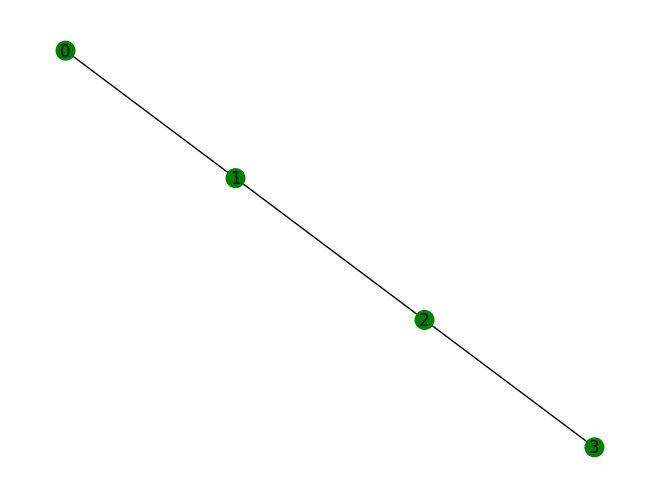

In [23]:
from qiskit.circuit.library import QFT, QuantumVolume
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile, QuantumCircuit
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, all_to_all, tree_network
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
import numpy as np
%load_ext jupyter_tikz

num_qubits = 32

seed = np.random.randint(0, 1000)

print(seed)

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5, seed=8360)

basis_gates = ['u', 'cp'] 
circuit = transpile(circuit, basis_gates=basis_gates)

num_partitions = 4  # Define the number of partitions or QPUs you will distribute over
depth = circuit.depth()

qpu_size = num_qubits // num_partitions + 1  # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.
# coupling = grid_coupling(num_partitions)
coupling = linear_coupling(num_partitions)  # Linear coupling for a linear topology
# coupling = all_to_all(num_partitions)  # Fully connected network

# coupling = [(0,1),(1,2),(2,3),(2,4)]
quantum_network = QuantumNetwork(qpu_sizes, qpu_connectivity=coupling)

# graph = QuantumCircuitHyperGraph(circuit, group_gates=False)

# fig = graph.draw(show_labels=False)
# display(fig)

graph = QuantumCircuitHyperGraph(circuit, group_gates=True)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

from disqco.parti.FM.fiduccia import *

FM_partitioner = FiducciaMattheyses(circuit=circuit,
                                    hypergraph=graph,
                                    network=quantum_network,
                                    graph=graph,
                                    initial_assignment=set_initial_partition_assignment(graph, quantum_network),
                                    )
quantum_network.draw()



# circuit.draw(output='mpl', style='bw', cregbundle=True, fold=50)

In [24]:
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

coarseneing_method = coarsener.coarsen_recursive_batches_mapped

results = FM_partitioner.multilevel_partition(coarsener=coarseneing_method)



Best cost: 127


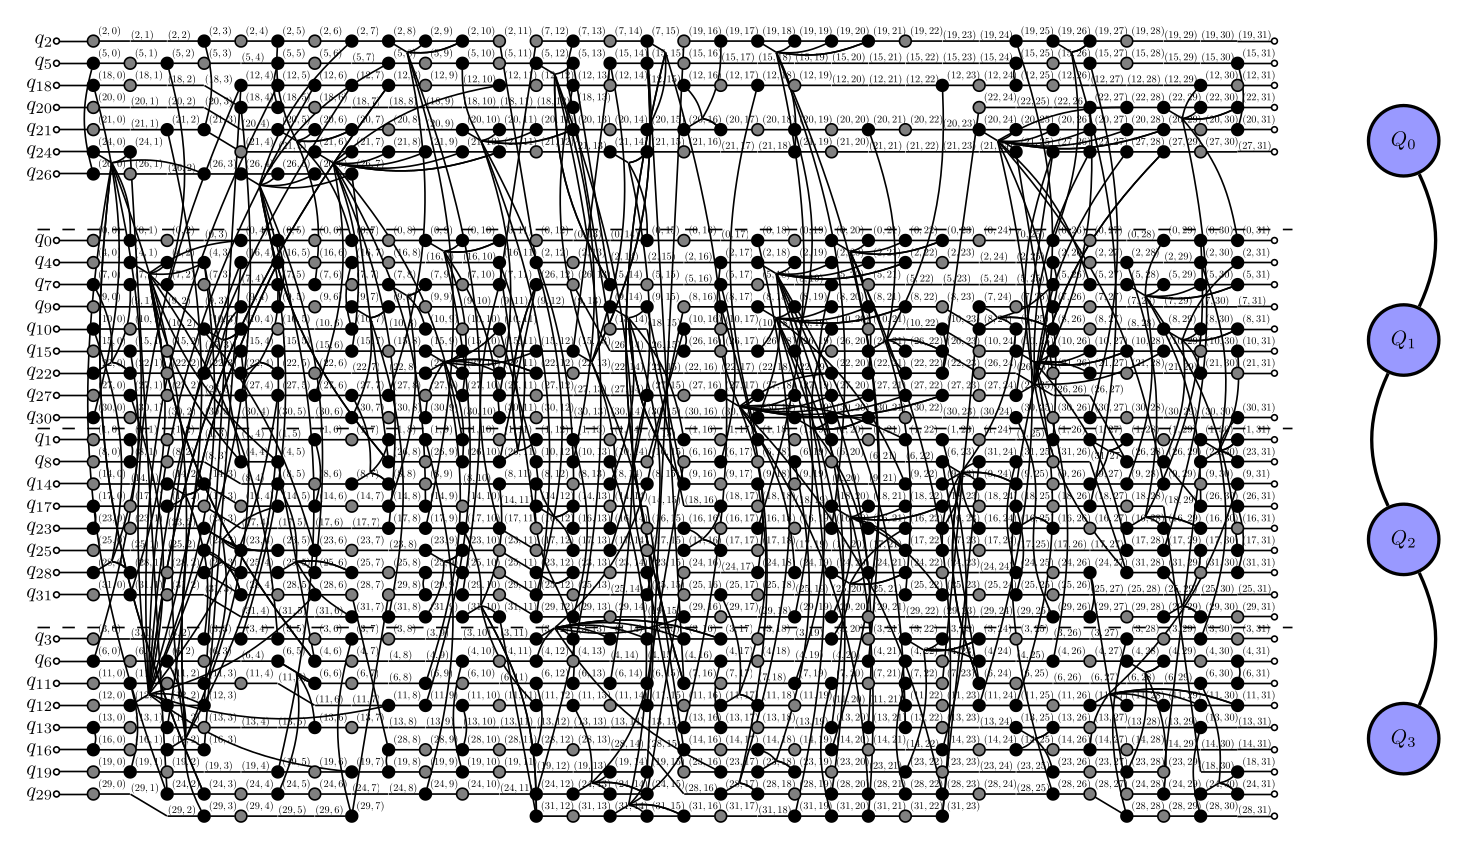

In [25]:
print(f'Best cost: {results['best_cost']}')

graph.draw(network=quantum_network,
           assignment=results['best_assignment'],dpi=300)

In [26]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        network=quantum_network, 
                                        partition_assignment=results['best_assignment'])

extracted_circuit = extractor.extract_partitioned_circuit()

In [28]:

print(f' Number of EPR pairs in circuit: {extracted_circuit.count_ops().get("EPR", 0)}')

extracted_circuit.remove_final_measurements()

extracted_circuit.draw(style='bw',output='mpl', cregbundle=True, fold=100)

 Number of EPR pairs in circuit: 127


In [22]:
from disqco.circuit_extraction.verification import check_no_cross_partition_gates

is_valid = check_no_cross_partition_gates(extracted_circuit, quantum_network.qpu_graph)
print("Circuit valid:", is_valid)

Circuit valid: True
